# TP3: Mean Shift

## Instructions
Read, understand, and complete the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). If you cannot/don't want to use notebooks, you can return both your python code and a report in pdf. 

Before sending your notebook, please make sure your code can be run by restarting your jupyter kernel and relaunching all the cells.

Return your work by e-mail at `gabriel.fiastre@inria.fr` using a single file (ipynb or zip) with the format `LASTNAME_FirstName_TP2.ipynb`

**During this TP, you will implement the Mean Shift algorithm for clustering, and use it for image sementation (pixel clustering)**

## Imports

In [412]:
# !pip3 install scikit-image
# Install scikit-image if you don't have it already

In [413]:
# See TP1 for information about those imports
import numpy as np
import matplotlib.pyplot as plt 
import scipy.ndimage as ndimage
plt.rcParams['image.cmap'] = 'gray' 

# For colorspace conversions in the last section
from skimage.color import rgb2lab,lab2rgb

## 1. Mean shift

In this section, we will implement Mean Shift and test it on simple synthetic data (*i.e.*, points you will sample from a probability distribution with known density - see below).

**1.a)** Generate a random vector of 100 2D points `data1` with: 
- 50 points sampled from a Gaussian distribution of variance (1, 1) centered in (0, 0),
- 50 points sampled from a Gaussian distribution of variance (1, 1) centered in (2, 1).<br/>

Plot your points using the `plt.scatter` function.

In [414]:
# Hint : consider using np.random.multivariate_normal
cov=[[1,0],[0,1]]
data1 = np.random.multivariate_normal((0,0),cov,50)
data1 = np.vstack((data1,np.random.multivariate_normal((2,1),cov,50)))

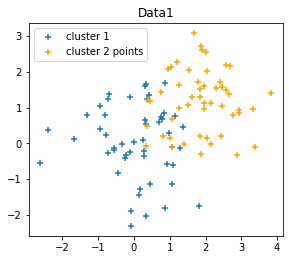

In [415]:
# Just an example of how to plot data, use your own code if you prefer
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
plt.scatter(data1[:50,0], data1[:50,1], marker="+", label="cluster 1")
plt.scatter(data1[50:,0], data1[50:,1], marker="+", color="orange", label="cluster 2 points")
plt.gca().set_aspect("equal")
plt.title("Data1")
plt.legend(loc="best")
plt.show()

**1.b)** Do the same to create a vector `data2` with the center of the second Gaussian in (3,3). 

In [416]:
# Hint : consider using np.random.multivariate_normal
cov=np.array([[1,0],[0,1]])
data2 = np.random.multivariate_normal((0,0),cov,50)
data2 = np.vstack((data2,np.random.multivariate_normal((3,3),cov,50)))

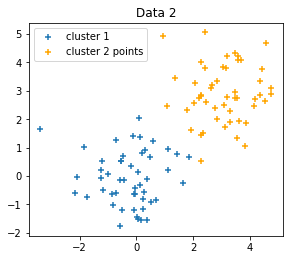

In [417]:
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
plt.scatter(data2[:50,0], data2[:50,1], marker="+", label="cluster 1")
plt.scatter(data2[50:,0], data2[50:,1], marker="+", color="orange", label="cluster 2 points")
plt.gca().set_aspect("equal")
plt.title("Data 2")
plt.legend(loc="best")
plt.show()

#### Note :
In the following, you will try to form clusters from the points in `data1` and `data2`. The algorithm you will develop should be able to separate the points coming from each of the two Gaussian distributions.

In each of the following experiment, **test on both `data1` and `data2`**.

**1.c)** After having visual comparison, which do you think will be the easiest `data` vector to cluster and why?

Data 2 should be easier since the gaussians are further apart from each other

In [418]:
data1 = np.random.multivariate_normal((0,0),cov,50)
data1 = np.vstack((data1,np.random.multivariate_normal((2,1),cov,50)))

data2 = np.random.multivariate_normal((0,0),cov,50)
data2 = np.vstack((data2,np.random.multivariate_normal((3,3),cov,50)))

In the end of this homework, we will segment images using a different **bandwidth** for space and color. For this reason, we will use **a *d*-dimensional vector `sigma`** as a parameter for all our mean-shift functions. It defines a scale for each dimension (*i.e.*, we want to do an anisotropic clustering). 

**2.** What is the role of the bandwith parameter(s) ? What would be a meaningful parameter `sigma` for each of the synthetic data sets (`data1` and `data2`)? Explain why.

The bandwith controls the radius of influence of a certain data point, performing a balance between bias and variance. The covariance of the gaussian source should provide a good bandwidth, as we can expect that the density will be maximized inside a window of this size.

In [419]:
sigma1 = np.diag(cov)
sigma2 = np.diag(cov)

The formula in the lectures are mostly derived for the isotropic case. The simple way to deal with the anisotropy is to divide each coordinate $x_i$ by its corresponding $\sigma_i$ rather than by a global $\sigma$ -- *e.g.* distance between points $\mathbf x$ and $\mathbf y$ normalized by $\sigma$ becomes $\sqrt{\sum_i^d{\left(\frac{\mathbf x_i- \mathbf y_i}{\sigma_i}\right)^2}}$.

**Bonus math question.** *(Answer it **only** when you have finished the TP)* What changes exactly in the anisotropic case? Why is doing that valid? What consequences does it have on gradients?

----

### Let's recall the Mean shift algorithm. 

Suppose you have data $X$, and an arbitrary kernel function $k$ (a comon example is the gaussian kernel) 

The target pdf to estimate would be defined as: 
$$f(X_j)=\frac{c}{N}\sum_i^N{k\left(||\frac{\mathbf X_j - \mathbf X_i}{\sigma_i}||^2\right)}$$
Note that $\sigma$ is the bandwith parameter, and $c$ a normalizing constant.

We now want to cluster the data points by finding for each the closest local minimum with respect to this pdf.

The Mean shift algorithm iterates as follows :

#### Mean Shift Algorithm

1. **Initialization:**
   - For each data point $X_j$, initialize the mean shift vector $M(X)$ to be zero.
   - Choose a bandwidth parameter $\sigma$ for your kernel function $k$ and $\epsilon$.

2. **Mean Shift Computation:**
   - For each point $X_j$, set $x\longleftarrow X_j$ and repeat until convergence:
     
     - Set  $x \leftarrow x + M(x)$
       
       with $M(x)$ the weighted average of the vectors pointing from $x$ to all other points in the dataset:
       
       This is :
       
       $$ M(x) = \frac{\sum_i^N X_i g\left(\frac{\|x - X_i\|^2}{\sigma^2}\right) }{\sum_i^N g\left(\frac{\|x - X_i\|^2}{\sigma^2}\right)} - x$$
       with $g(x)=-k'(x)$ the direction

      If $M(x)<\epsilon$, stop

   - Assign $X_j$ to the found minimum $x^*$, called **mode** 


3. **Return Modes and labels for all points (with eventually some post-processing such as merging close nodes etc.)**

**3.a)** Implement the function `MS_step` which takes as input a vector of all the data points `data`, a starting point `x`, the standard deviations `sigma` and an arbitrary kernel fucntion and returns the updated position of the point `x` after one step of the mean-shift algorithm. <br/>


**3.b)** Test it on your synthetic data (on `data1`, then on `data2`) and visualize the result.

In [420]:
def g(x, sigma):
    """
    Implements a Gaussian kernel
    """
    norm = np.linalg.norm(np.divide(x,sigma),axis=1)
    return np.exp(-norm**2/2).reshape(-1,1)

def MS_step(data, x, sigma, g_function=g):
    """
    Performs one step of the algorithm
    """
    a = np.sum(data*g_function(data-x,sigma),axis=0)
    b = np.sum(g_function(data-x,sigma),axis=0)
    return a/b

Testing for data1

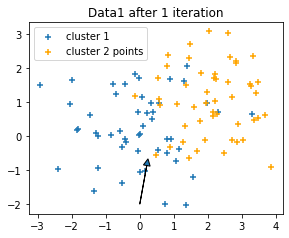

In [421]:
x=np.array([0,-2]) #initializing point
vector = MS_step(data1, x, sigma1, g_function=g) - x #mean shift vector
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
plt.scatter(data1[:50,0], data1[:50,1], marker="+", label="cluster 1")
plt.scatter(data1[50:,0], data1[50:,1], marker="+", color="orange", label="cluster 2 points")
plt.gca().set_aspect("equal")
plt.title("Data1 after 1 iteration")
plt.legend(loc="best")
plt.arrow(x[0],x[1],vector[0],vector[1],head_width=0.2, head_length=0.2)
plt.show()

Testing for data2

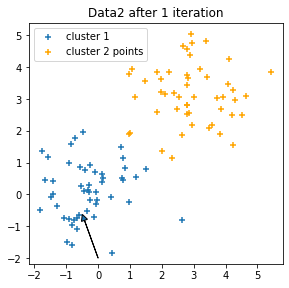

In [422]:
x=np.array([0,-2]) #initializing point
vector = MS_step(data2, x, sigma1, g_function=g) - x #mean shift vector
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
plt.scatter(data2[:50,0], data2[:50,1], marker="+", label="cluster 1")
plt.scatter(data2[50:,0], data2[50:,1], marker="+", color="orange", label="cluster 2 points")
plt.gca().set_aspect("equal")
plt.title("Data2 after 1 iteration")
plt.legend(loc="best")
plt.arrow(x[0],x[1],vector[0],vector[1],head_width=0.2, head_length=0.2)
plt.show()

**4.a)** Implement the function `MS_point` which iterates `MS_step` until convergence (*e.g.*, until the estimate changes by less than $\epsilon=0.01$).<br/>

It should return $x^*$, the **mode** associated to the point $x$ after convergence.
You should not modify the original data which would break the algorithm.

**4.b)** Test it on your synthetic data and visualize the results.

In [423]:
def MS_point(data, x, sigma, eps=0.01, g_function=g):
    """
    Iterates the algorithm until convergence for a single point
    """
    dist = eps+1
    x_old = x
    while dist > eps:
        x_star = MS_step(data, x_old, sigma, g_function)
        dist = np.linalg.norm(x_star-x_old)
        x_old = x_star
    return x_star

Testing Data1

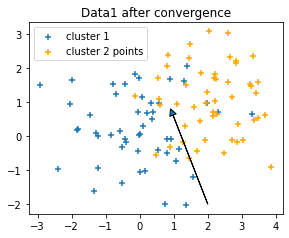

In [424]:
x=np.array([2,-2]) #initializing point
vector = MS_point(data1, x, sigma1) - x #mean shift vector
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
plt.scatter(data1[:50,0], data1[:50,1], marker="+", label="cluster 1")
plt.scatter(data1[50:,0], data1[50:,1], marker="+", color="orange", label="cluster 2 points")
plt.gca().set_aspect("equal")
plt.title("Data1 after convergence")
plt.legend(loc="best")
plt.arrow(x[0],x[1],vector[0],vector[1],head_width=0.2, head_length=0.2)
plt.show()

Testing Data2

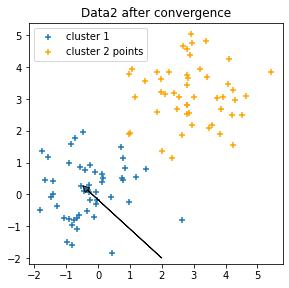

In [425]:
x=np.array([2,-2]) #initializing point
vector = MS_point(data2, x, sigma1) - x #mean shift vector
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
plt.scatter(data2[:50,0], data2[:50,1], marker="+", label="cluster 1")
plt.scatter(data2[50:,0], data2[50:,1], marker="+", color="orange", label="cluster 2 points")
plt.gca().set_aspect("equal")
plt.title("Data2 after convergence")
plt.legend(loc="best")
plt.arrow(x[0],x[1],vector[0],vector[1],head_width=0.2, head_length=0.2)
plt.show()

**5.a)** Implement the `MS` function, which implements the full mean shift algorithm by iterating `MS_point` on all the points, and merging modes so that there are not two modes at distance -- normalized by `sigma` -- smaller than 0.5, and such that all points are assigned to the closest mode, at a distance smaller than 0.5. <br/>
The function must return a list of the modes and a label (corresponding to a mode) for each point. <br/>

**5.b)** Test it on your synthetic data and visualize the results for different values of `sigma`. <br/>

**5.c)** Comment on the result for each `data` vector and the different `sigma`.

In [426]:
def MS(data, sigma, eps=0.01, g_function=g):
    """
    Performs the mean shift algorithm for the entire dataset
    """
    labels = np.zeros([data.shape[0]])
    modes = np.zeros([0, data.shape[1]])
    #Getting the modes
    for i,point in enumerate(data):
        new_mode = MS_point(data, point, sigma, eps, g_function)
        #initializing the modes array
        if i == 0:
           modes = np.vstack([modes, new_mode]) 
        dist = np.linalg.norm(np.divide(new_mode-modes,sigma),axis=1)
        closest = np.argmin(dist)
        if dist[closest] > 0.5:
            modes = np.vstack([modes, new_mode])
    #Assigning the modes to the points
    num_modes, dim = modes.shape
    num_points, _ = data.shape
    modes_tile = np.tile(modes, [num_points, 1]).reshape([num_points, num_modes, dim])
    points_tile = np.tile(data, [1, num_modes]).reshape([num_points, num_modes, dim])
    distances = np.linalg.norm(np.divide(modes_tile - points_tile,sigma), axis=2)
    labels = np.argmin(distances, axis=1)

    return labels, modes

In [427]:
def plot_mean_shift(data, sigmas):
    """
    Runs the mean shift and plots the result for different values of sigma   
    """
    
    fig, axs = plt.subplots(1, len(sigmas), figsize=(len(sigmas)*6, 5))
    axs = np.array([axs]) if len(sigmas) == 1 else axs

    for idx, sigma in enumerate(sigmas):
        labels, modes = MS(data, sigma)
        u_labels = np.arange(len(modes))
        for i in u_labels:
            axs[idx].scatter(data[labels == i, 0], data[labels == i, 1], label=f'Cluster {i+1}')
        axs[idx].scatter(modes[:, 0], modes[:, 1], s=100, marker='+', c='red')
        axs[idx].set_aspect("equal")
        axs[idx].set_title(f"Sigma = {sigma}")
        axs[idx].legend(loc="best")
    
    plt.tight_layout()
    plt.show()



For the tests, the value of sigma is a scalar that will be broadcast to the data dimensions, but the function also works with sigmas that are vectors


Results for **data1**

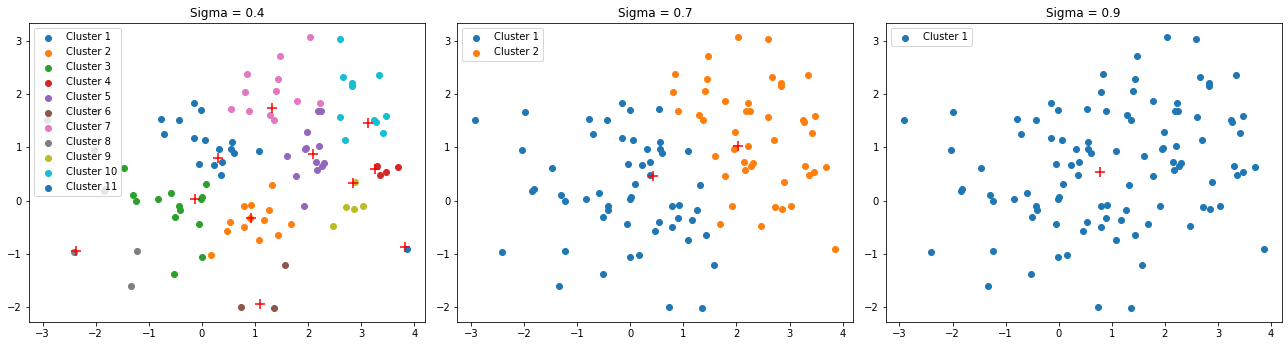

In [445]:
sigma=[0.4,0.7,0.9]
plot_mean_shift(data1,sigma)

The structure of the data1, with two gaussian sources that are very close to each other, makes the selection of the adequate sigma more challenging. Through the plot, we can see that a small variation of the sigma made us go from 11 clusters identified in the data set to only 1.

Results for **data2**

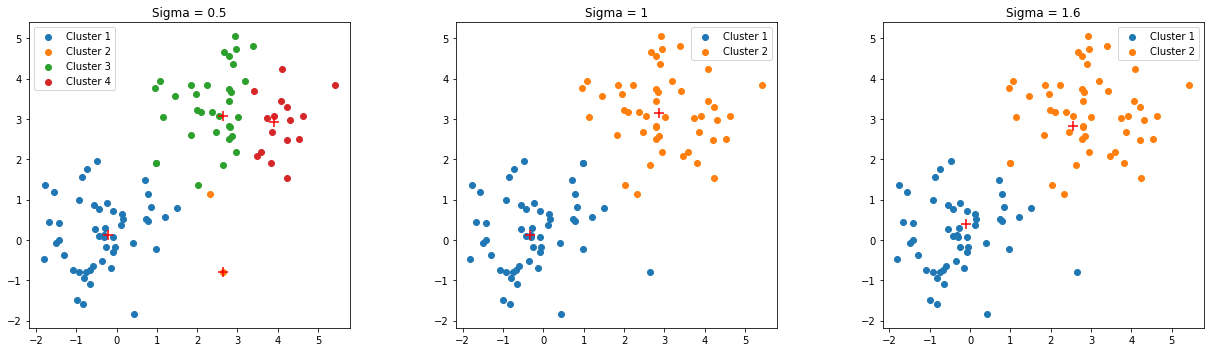

In [447]:
sigma=[0.5,1,1.6]
plot_mean_shift(data2,sigma)

In the case of data2, the gaussian sources are further apart from each other. Therefore, we can see the expected result (2 clusters) is more robust against the variation of the sigma.

## 2. Segmentation

**6.a)** Load the image `veggies_small.jpg` it and convert it to the `Lab` colorspace. <br/>


In [430]:
filename = 'veggies_small.jpg'
rgb = plt.imread(filename)
lab = rgb2lab(rgb)

**6.b)** Why is it necessary to change the colorspace? What are the ranges of the colorvalues for this image in the Lab space ?

This new colorspace adds a dimension of intensity of lightness, which will be useful when clustering the elements of the image

In [431]:
print("Ranges of channel a*",lab[:,:,1].min(),lab[:,:,1].max())
print("Ranges of channel b*",lab[:,:,2].min(),lab[:,:,2].max())

Ranges of channel a* -34.86842703148147 43.95147934802623
Ranges of channel b* -22.866041694886107 51.40709947253017


In Mean Shift segmentation, all pixels in the image will be treated as data points including both their color and position in the image.

**7.a)** Convert the *(N, M, 3)* image into an *(NM, 5)* array incuding color and position information for each point. *(Tip: use the `np.meshgrid` function)* <br/>
**b)** What would be a meaningful value for `sigma`?

In [432]:
#7 a)
N, M, _ = lab.shape
x, y = np.meshgrid(np.arange(M), np.arange(N))
cartesian_product = np.column_stack([y.flatten(), x.flatten()])
# Reshaping the image array to match the positions
reshaped_image = lab.reshape(-1, 3)
# Combining color and position information
combined_array = np.concatenate((reshaped_image, cartesian_product), axis=1)
combined_array

array([[89.05178892,  1.21117293, -1.22096119,  0.        ,  0.        ],
       [89.05178892,  1.21117293, -1.22096119,  0.        ,  1.        ],
       [89.05178892,  1.21117293, -1.22096119,  0.        ,  2.        ],
       ...,
       [95.34656791,  1.21980719, -2.28168737, 61.        , 47.        ],
       [95.34656791,  1.21980719, -2.28168737, 61.        , 48.        ],
       [95.34656791,  1.21980719, -2.28168737, 61.        , 49.        ]])

In [448]:
#7 b) A initial estimate for the bandwidth can be the standard deviation of the columns
sigma = np.std(combined_array, axis=0)
sigma

array([22.71186872, 13.01932923, 13.42397039, 17.89553017, 14.43086969])

**8.a)** Use the `MS` function from the previous section to compute a meaningful segmentation of the image. <br/>
*(Tip: if your `MS` function is too slow, it might be because of your function`MS_step`, or because of mode merging. Try to rewrite your answers replacing some python loops with `np.sum` and other built-in `numpy` functions that are much faster.)* <br/>

In [434]:
labels, modes = MS(combined_array,sigma/2)

In [435]:
modes

array([[ 90.48714273,   0.75696579,  -0.3579066 ,  13.25756509,
          5.92284864],
       [ 86.2803751 ,   0.36230601,  -0.15922211,  10.27791955,
         45.49406222],
       [ 83.48720703, -13.39057542,  22.57168056,   7.15421459,
         31.68832468],
       [ 41.36608506, -27.23814179,  38.58141966,  15.26844436,
         39.76997594],
       [ 43.92564101, -13.04635193,  16.89988258,  25.70721806,
         26.40227172],
       [ 36.01567765,  24.96552159,  32.04806978,  16.79438321,
         22.14697879],
       [ 42.89841446, -28.82946223,  40.77582401,  23.53528883,
         12.98638931],
       [ 91.06873055,   1.31221345,  -1.28703148,  51.59040722,
         43.74789786],
       [ 95.25526175,   0.43576888,  -0.11472766,  49.90822624,
          7.87315569],
       [ 81.79870765, -12.54447772,  21.3238229 ,  36.76954474,
         14.45514811],
       [ 46.45749674,  21.6021703 ,  -6.68495408,  48.53716083,
         27.66368123]])

**8.b)** Visualize the result as an image by replacing the color values of each pixel with its associated mode (ie. with its label) <br/>

In [436]:
def plot_MS_legumes(img, sigma):
    """
    Takes an image in Lab format and performs the mean shift algorithm
    """
    N, M, _ = img.shape
    x, y = np.meshgrid(np.arange(M), np.arange(N))
    cartesian_product = np.column_stack([y.flatten(), x.flatten()])
    # Reshaping the image array to match the positions
    reshaped_image = img.reshape(-1, 3)
    # Combining color and position information
    combined_array = np.concatenate((reshaped_image,cartesian_product), axis=1)
    labels, modes = MS(combined_array,sigma)
    labels = labels.reshape((img.shape[0], img.shape[1]))
    mode_img = np.zeros_like(img)
    for coord, label in np.ndenumerate(labels):
        mode_img[coord] = modes[label][:3] # Take the first 3 channels for Lab values !
    
    plt.imshow(lab2rgb(mode_img))
    plt.show()

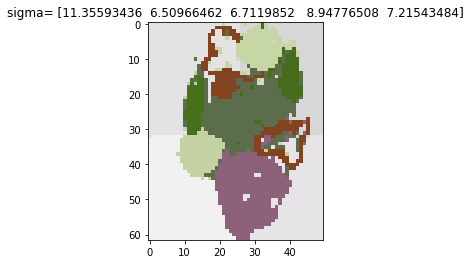

In [449]:
plt.title(f"sigma= {sigma/2}")
plot_MS_legumes(lab, sigma/2)

**8.c)** Experiment with different `sigma` values and comment on the results.

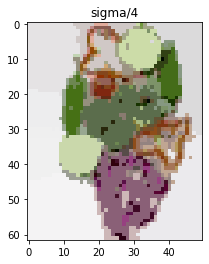

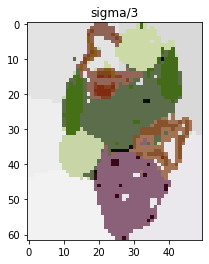

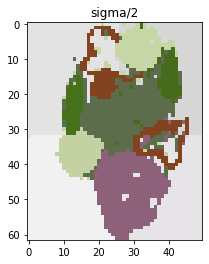

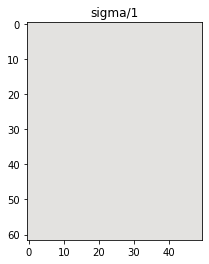

In [438]:
#sigma is still equal to the standard deviation of each column
# we will then scale that for the tests
factors = [4,3,2,1]
for factor in factors:
    plt.title(f"sigma/{factor}")
    plot_MS_legumes(lab,sigma/factor)

As was the case with the synthetic data, lower values of sigma bring more noise to the result, while values that are too large smooth out the clusters and eliminate the details. The best balance was reached with sigma/2, which was able to assign a single cluster to most of the vegetables present in the image.